In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from functools import partial
import uproot

from awkward import JaggedArray
import numpy as np
import pickle

from coffea.lookup_tools import extractor, dense_lookup

import matplotlib.pyplot as plt
from matplotlib import ticker,colors

In [2]:
from utils.crossSections import *
from utils.efficiencies import getMuSF, getEleSF


In [3]:
with open('taggingEfficienciesDenseLookup.pkl','rb') as _file:
    taggingEffLookup = pickle.load(_file)

In [4]:
# Look at ProcessorABC to see the expected methods and what they are supposed to do
class TTGammaProcessor(processor.ProcessorABC):
#     def __init__(self, runNum = -1, eventNum = -1):
    def __init__(self, runNum = -1, eventNum = -1, mcEventYields = None):
        dataset_axis = hist.Cat("dataset", "Dataset")
        year_axis = hist.Cat("year",r"Year")
        
        Npho_axis = hist.Bin("nPho", r"$Number of Photons$", 3, 0., 3)
        Nbjet_axis = hist.Bin("nBjet", r"BJet Multiplicity", 3, 0, 3)
        lep_axis = hist.Bin("lepFlavor", r"ElectronOrMuon", 3, -1.5, 1.5)
        
        m3_axis = hist.Bin("M3", r"$M_3$ [GeV]", 1000, 0., 1000)
        pt_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 200, 0., 1000)
        genpt_axis = hist.Bin("genpt", r"$Gen p_{T,\gamma}$ [GeV]", 200, 0., 1000)
        eta_axis = hist.Bin("eta", r"$\eta_{\gamma}$", 300, -1.5, 1.5)
        geneta_axis = hist.Bin("geneta", r"$Gen \eta_{\gamma}$", 300, -1.5, 1.5)
        sieie_axis = hist.Bin("sieie", r"$\sigma_{i\eta i\eta}$", 100, 0., 0.1)
        chIso_axis = hist.Bin("chIso", r"Charged Hadron Isolation", 200, 0., 20.)
        dR_axis = hist.Bin("dR", r"$\Delta R$", 600, 0., 6)
        mult_axis = hist.Bin("N", r"Multiplicity", 10, 0, 10)

        ## Define axis to keep track of photon category
        phoCategory_axis = hist.Bin("category", r"Photon Category", [1,2,3,4,5])
        phoCategory_axis.identifiers()[0].label = "Genuine Photon"    
        phoCategory_axis.identifiers()[1].label = "Misidentified Electron"    
        phoCategory_axis.identifiers()[2].label = "Hadronic Photon"    
        phoCategory_axis.identifiers()[3].label = "Hadronic Fake"    
        
        ###
        self._accumulator = processor.dict_accumulator({
            ##photon histograms
            'photon_pt': hist.Hist("Counts", dataset_axis, pt_axis, phoCategory_axis, year_axis,lep_axis),
            'photon_eta': hist.Hist("Counts", dataset_axis, eta_axis, phoCategory_axis, year_axis,lep_axis),
            'photon_sieie': hist.Hist("Counts", dataset_axis, sieie_axis, phoCategory_axis, year_axis,lep_axis),
            'photon_chIso': hist.Hist("Counts", dataset_axis, chIso_axis, phoCategory_axis, year_axis,lep_axis),
            'dR_lep_gamma': hist.Hist("Counts", dataset_axis, dR_axis,phoCategory_axis, year_axis,lep_axis),

            ##photon reco vs gen histograms
            'photon_RecoVsGenPt': hist.Hist("Counts", dataset_axis, pt_axis,genpt_axis, phoCategory_axis, year_axis,lep_axis),
            'photon_RecoVsGenEta': hist.Hist("Counts", dataset_axis, eta_axis,geneta_axis, phoCategory_axis, year_axis,lep_axis),

            ##jet histograms (split by nBjet, nPhoton, and lepton flavor)
            'pt_jet': hist.Hist("Counts", dataset_axis, pt_axis, year_axis,Npho_axis,Nbjet_axis,lep_axis),
            'jet_mult': hist.Hist("Counts", dataset_axis, mult_axis, year_axis,Npho_axis,Nbjet_axis,lep_axis),
            'M3': hist.Hist("Counts", dataset_axis, m3_axis, year_axis,Npho_axis,Nbjet_axis,lep_axis),

        })

        self.eventNum = eventNum
        self.runNum = runNum
        
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()

        datasetFull = df['dataset']
        if '2016' in datasetFull:
            year=2016
            yearStr="2016"
            muonTrigger = df['HLT_IsoMu24'] | df['HLT_IsoTkMu24']
            eleTrigger = df['HLT_Ele27_WPTight_Gsf']
            photonBitMapName = 'Photon_cutBased'
            btagSF = 'test_DeepCSV_2016LegacySF_V1.btag.csv'
            dataset=datasetFull.replace('_2016','')
        elif '2017' in datasetFull:
            year=2017
            yearStr="2017"
            muonTrigger = df['HLT_IsoMu27']
            eleTrigger = df['HLT_Ele32_WPTight_Gsf_L1DoubleEG'] | df['HLT_Ele32_WPTight_Gsf']
            photonBitMapName = 'Photon_cutBasedBitmap'
            btagSF = 'test_DeepCSV_102XSF_V1.btag.csv'
            dataset=datasetFull.replace('_2017','')
        elif '2018' in datasetFull:
            year=2018
            yearStr="2018"
            muonTrigger = df['HLT_IsoMu24']
            eleTrigger = df['HLT_Ele32_WPTight_Gsf']
            photonBitMapName = 'Photon_cutBasedBitmap'
            btagSF = 'test_DeepCSV_102XSF_V1.btag.csv'
            dataset=datasetFull.replace('_2018','')

        nMCevents = mcEventYields[datasetFull]
        xsec = crossSections[dataset]
        
        
        filters = (df['Flag_goodVertices'] &
                   df['Flag_globalSuperTightHalo2016Filter'] &
                   df['Flag_HBHENoiseFilter'] &
                   df['Flag_HBHENoiseIsoFilter'] &
                   df['Flag_EcalDeadCellTriggerPrimitiveFilter'] &
                   df['Flag_BadPFMuonFilter'] 
                  )
        if year > 2016:
            filters = (filters & 
                       df['Flag_ecalBadCalibFilterV2']
                      )
        
        
        
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'],
            eta=df['Muon_eta'],
            phi=df['Muon_phi'],
            mass=df['Muon_mass'],
            charge=df['Muon_charge'],
            relIso=df['Muon_pfRelIso04_all'],
            tightId=df['Muon_tightId'],
            isPFcand=df['Muon_isPFcand'],
            isTracker=df['Muon_isTracker'],
            isGlobal=df['Muon_isGlobal'],           
        )
        
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt=df['Electron_pt'],
            eta=df['Electron_eta'],
            phi=df['Electron_phi'],
            mass=df['Electron_mass'],
            charge=df['Electron_charge'],
            cutBased=df['Electron_cutBased'],
            d0=df['Electron_dxy'],
            dz=df['Electron_dz'],
        )

        jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'],
            eta=df['Jet_eta'],
            phi=df['Jet_phi'],
            mass=df['Jet_mass'],
            jetId=df['Jet_jetId'],
            btag=df['Jet_btagDeepB'],
            hadFlav=df['Jet_hadronFlavour'],
            genIdx=df['Jet_genJetIdx'],
        )

        photons = JaggedCandidateArray.candidatesfromcounts(
            df['nPhoton'],
            pt=df['Photon_pt'],
            eta=df['Photon_eta'],
            phi=df['Photon_phi'],
            mass=np.zeros_like(df['Photon_pt']),
            isEE=df['Photon_isScEtaEE'],
            isEB=df['Photon_isScEtaEB'],
            photonId=df[photonBitMapName],
            passEleVeto=df['Photon_electronVeto'],
            pixelSeed=df['Photon_pixelSeed'],
            #genFlav=df['Photon_genPartFlav'],
            genIdx=df['Photon_genPartIdx'],
            sieie=df['Photon_sieie'],
            chIso=df['Photon_pfRelIso03_chg'],
            vidCuts=df['Photon_vidNestedWPBitmap'],
        )
            
        genPart = JaggedCandidateArray.candidatesfromcounts(
            df['nGenPart'],
            pt=df['GenPart_pt'],
            eta=df['GenPart_eta'],
            phi=df['GenPart_phi'],
            mass=df['GenPart_mass'],
            pdgid=df['GenPart_pdgId'],
            motherIdx=df['GenPart_genPartIdxMother'],
            status=df['GenPart_status'],
            statusFlags=df['GenPart_statusFlags'],
        )


        ## TTbar vs TTGamma Overlap Removal (work in progress, still buggy)
#         overlapRemoval = np.ones_like(df['event'])
#         if 'TTbar' in dataset:
#             overlapPhoSelect = ((genPart.pt>=10) & 
#                                 (abs(genPart.eta) < 5.) & 
#                                 (genPart.pdgid==22) & 
#                                 (genPart.status==1)
#                                )
            
#             OverlapPhotons = genPart[overlapPhoSelect] 

#             phoParent = OverlapPhotons.motherIdx
#             phoParent = phoParent[phoParent>-1]
#             isNonPrompt = (genPart[phoParent].pdgid>25).any()

#             while (phoParent>-1).any().sum()>0:
#                 phoParent = phoParent[phoParent>-1]
#                 isNonPrompt = isNonPrompt | (genPart[phoParent].pdgid>37).any()
#                 phoParent = genPart[phoParent].motherIdx        
#             ### Add in min DR cut
            

        
        
        muonSelectTight = ((muons.pt>30) & 
                           (abs(muons.eta)<2.4) & 
                           (muons.tightId) & 
                           (muons.relIso < 0.15)
                          )
        
        muonSelectLoose = ((muons.pt>15) & 
                           (abs(muons.eta)<2.4) & 
                           ((muons.isPFcand) & (muons.isTracker | muons.isGlobal)) & 
                           (muons.relIso < 0.25) &
                           np.invert(muonSelectTight)
                          )

        eleEtaGap = (abs(electrons.eta) < 1.4442) | (abs(electrons.eta) > 1.566)
        elePassD0 = ((abs(electrons.eta) < 1.479) & (abs(electrons.d0) < 0.05) |
                     (abs(electrons.eta) > 1.479)  & (abs(electrons.d0) < 0.1)
                    )
        elePassDZ = ((abs(electrons.eta) < 1.479) & (abs(electrons.dz) < 0.1) |
                     (abs(electrons.eta) > 1.479)  & (abs(electrons.dz) < 0.2)
                    )

        
        
        electronSelectTight = ((electrons.pt>35) & 
                               (abs(electrons.eta)<2.1) & 
                               eleEtaGap &      
                               (electrons.cutBased>=4) &
                               elePassD0 & 
                               elePassDZ
                              )

        electronSelectLoose = ((electrons.pt>15) & 
                               (abs(electrons.eta)<2.4) & 
                               eleEtaGap &      
                               (electrons.cutBased>=1) &
                               elePassD0 & 
                               elePassDZ & 
                               np.invert(electronSelectTight)
                              )
        
        tightMuon = muons[muonSelectTight]
        looseMuon = muons[muonSelectLoose]
        
        tightElectron = electrons[electronSelectTight]
        looseElectron = electrons[electronSelectLoose]

        

                
        oneMuon = (tightMuon.counts == 1)
        muVeto = (tightMuon.counts == 0)
        oneEle = (tightElectron.counts == 1)
        eleVeto = (tightElectron.counts == 0)
        looseMuonSel = (looseMuon.counts == 0)
        looseElectronSel = (looseElectron.counts == 0)

        
        #### Calculate deltaR between photon and nearest muon
        ####### make combination pairs
        phoMu = photons['p4'].cross(tightMuon['p4'],nested=True)
        ####### check delta R of each combination, if min is >0.1 it is okay, or if there are no tight muons it passes
        dRphomu = (phoMu.i0.delta_r(phoMu.i1)>0.4).all() | (tightMuon.counts==0)
        phoEle = photons['p4'].cross(tightElectron['p4'],nested=True)
        dRphoele = ((phoEle.i0.delta_r(phoEle.i1)).min()>0.4) | (tightElectron.counts==0)
        
        #photon selection (no ID requirement used here)
        photonSelect = ((photons.pt>20) & 
                        (abs(photons.eta) < 1.4442) &
                        (photons.isEE | photons.isEB) &
                        (photons.passEleVeto) & 
                        np.invert(photons.pixelSeed) & 
                        dRphomu & dRphoele
                       )
        
        
        #split out the ID requirement, enabling Iso and SIEIE to be inverted for control regions
        photonID = photons.photonId >= 2

        #parse VID cuts, define loose photons (not used yet)
        photon_MinPtCut = (photons.vidCuts>>0 & 3)>=2 
        photon_PhoSCEtaMultiRangeCut = (photons.vidCuts>>2 & 3)>=2 
        photon_PhoSingleTowerHadOverEmCut = (photons.vidCuts>>4 & 3)>=2  
        photon_PhoFull5x5SigmaIEtaIEtaCut = (photons.vidCuts>>6 & 3)>=2  
        photon_PhoAnyPFIsoWithEACut = (photons.vidCuts>>8 & 3)>=2  
        photon_PhoAnyPFIsoWithEAAndQuadScalingCut = (photons.vidCuts>>10 & 3)>=2  
        photon_PhoAnyPFIsoWithEACut = (photons.vidCuts>>12 & 3)>=2  
        
        loosePhotonID = photon_PhoSingleTowerHadOverEmCut & photon_PhoAnyPFIsoWithEACut & photon_PhoAnyPFIsoWithEAAndQuadScalingCut & photon_PhoAnyPFIsoWithEACut

        
        tightPhotons = photons[photonSelect & photonID]

        
        ##medium jet ID cut
        jetIDbit = 1
        if year>2016: jetIDbit=2

        ##check dR jet,lepton & jet,photon
        jetMu = jets['p4'].cross(tightMuon['p4'],nested=True)
        dRjetmu = ((jetMu.i0.delta_r(jetMu.i1)).min()>0.4) | (tightMuon.counts==0)

        jetEle = jets['p4'].cross(tightElectron['p4'],nested=True)
        dRjetele = ((jetEle.i0.delta_r(jetEle.i1)).min()>0.4) | (tightElectron.counts==0)

        jetPho = jets['p4'].cross(tightPhotons['p4'],nested=True)
        dRjetpho = ((jetPho.i0.delta_r(jetPho.i1)).min()>0.1) | (tightPhotons.counts==0)
        
        jetSelect = ((jets.pt > 30) &
                     (abs(jets.eta) < 2.4) &
                     ((jets.jetId >> jetIDbit & 1)==1) &
                     dRjetmu & dRjetele & dRjetpho                    
                    )

        tightJets = jets[jetSelect]
        
        bTagWP = 0.6321
        if year == 2017:
            bTagWP = 0.4941
        if year == 2018:
            bTagWP = 0.4184

        btagged = tightJets.btag>bTagWP

        bJets = tightJets[btagged]

        ## Define M3, mass of 3-jet pair with highest pT
        triJet = tightJets['p4'].choose(3)

        triJetPt = (triJet.i0 + triJet.i1 + triJet.i2).pt
        triJetMass = (triJet.i0 + triJet.i1 + triJet.i2).mass
        M3 = triJetMass[triJetPt==triJetPt.max()]


        leadingPhoton = tightPhotons[:,:1]

        #calculate dR lepton,photon
        gammaMu = leadingPhoton['p4'].cross(tightMuon['p4'],nested=True)
        dRgammaMu = (gammaMu.i0.delta_r(gammaMu.i1)).min()
        gammaEle = leadingPhoton['p4'].cross(tightElectron['p4'],nested=True)
        dRgammaEle = (gammaEle.i0.delta_r(gammaEle.i1)).min()

        dRgammaLep = np.minimum(dRgammaMu,dRgammaEle)        

        
        #### Photon categories, using genIdx branch
        # reco photons really generated as electrons
        isMisIDele = (abs(genPart[leadingPhoton.genIdx].pdgid)==13).any()

        matchedPho = (abs(genPart[leadingPhoton.genIdx].pdgid)==22).any()

        # look through parentage to find if any hadrons in genPhoton parent history
        genParent = genPart[leadingPhoton.genIdx].motherIdx
        isHadPho = (genPart[leadingPhoton.genIdx].pdgid>25).any()
        while (genParent>-1).any().sum()>0:
            genParent = genParent[genParent>-1]
            isHadPho = isHadPho | (genPart[genParent].pdgid>25).any()
            genParent = genPart[genParent].motherIdx

        
        isHadFake = (leadingPhoton.genIdx==-1).any()
        isHadFake = isHadFake & np.invert(isHadPho)

        isGenPho = matchedPho & np.invert(isHadPho)

        #define integer definition for the photon category axis
        phoCategory = 1*isGenPho + 2*isMisIDele + 3*isHadPho + 4*isHadFake

        
        #define selection levels (for cutflow synchronization)
        mu_trigger = muonTrigger        
        mu_filter = mu_trigger & filters
        mu_oneMu = oneMuon & mu_filter
        mu_noEle = eleVeto & mu_oneMu
        mu_noLoose = looseMuonSel & looseElectronSel & mu_noEle
        mu_twoJet = (tightJets.counts >= 2) & mu_noLoose
        mu_threeJet = (tightJets.counts >= 3) & mu_noLoose
        mu_jetSel = (tightJets.counts >= 4) & mu_noLoose
        mu_bjetSel = (bJets.counts >= 2) & mu_jetSel
        mu_presel = mu_bjetSel
        mu_phosel = (tightPhotons.counts >= 1) & mu_bjetSel

        ele_trigger = eleTrigger
        ele_filter = ele_trigger & filters
        ele_oneEle = oneEle & ele_filter
        ele_noMu = muVeto & ele_oneEle
        ele_noLoose = looseMuonSel & looseElectronSel & ele_noMu
        ele_twoJet = (tightJets.counts >= 2) & ele_noLoose
        ele_threeJet = (tightJets.counts >= 3) & ele_noLoose
        ele_jetSel = (tightJets.counts >= 4) & ele_noLoose
        ele_bjetSel = (bJets.counts >= 2) & ele_jetSel
        ele_presel = ele_bjetSel
        ele_phosel = (tightPhotons.counts >= 1) & ele_bjetSel

        
        
        lep_jetSel = mu_jetSel | ele_jetSel
        lep_bjetSel = mu_bjetSel | ele_bjetSel
        lep_phosel = mu_phosel | ele_phosel
        
        lepFlavor = -1*ele_noLoose + 1*mu_noLoose
        

        #get leading generated photon, for 
        genPhotonSel =  ((genPart.pdgid==22) &
                         (genPart.statusFlags&1==1) &
                         (genPart.statusFlags>>13&1==1))
        genPhotons = genPart[genPhotonSel]
        
        #find highest Pt, otherwise they are sorted by gen history
        leadingGenPhoton = genPhotons[genPhotons.pt==genPhotons.pt.max()]
    
        ext = extractor()
        ext.add_weight_sets(["btag * ScaleFactors/Btag/%s"%btagSF])
        ext.finalize()
        evaluator = ext.make_evaluator()
        
        #btag key name
        #name / working Point / type / systematic / jetType
        #  ... / 0-loose 1-medium 2-tight / comb,mujets,iterativefit / central,up,down / 0-b 1-c 2-udcsg 
        bJetSF = evaluator['btagDeepCSV_1_comb_central_0'](tightJets.eta, tightJets.pt, tightJets.btag)
        bJetSF_c = evaluator['btagDeepCSV_1_comb_central_1'](tightJets.eta, tightJets.pt, tightJets.btag)
        bJetSF_udcsg = evaluator['btagDeepCSV_1_incl_central_2'](tightJets.eta, tightJets.pt, tightJets.btag)

        bJetSF.content[(tightJets.hadFlav==4).content] = bJetSF_c[tightJets.hadFlav==4].content
        bJetSF.content[(tightJets.hadFlav==0).content] = bJetSF_udcsg[tightJets.hadFlav==0].content
        

        ## mc efficiency lookup, data efficiency is eff* scale factor
        btagEfficiencies = taggingEffLookup(datasetFull,tightJets.hadFlav,tightJets.pt,tightJets.eta)
        btagEfficienciesData = btagEfficiencies*bJetSF

        ##probability is the product of all efficiencies of tagged jets, times product of 1-eff for all untagged jets
        ## https://twiki.cern.ch/twiki/bin/view/CMS/BTagSFMethods#1a_Event_reweighting_using_scale
        pMC   = btagEfficiencies[btagged].prod()     * (1.-btagEfficiencies[np.invert(btagged)]).prod() 
        pData = btagEfficienciesData[btagged].prod() * (1.-btagEfficienciesData[np.invert(btagged)]).prod()
        btagWeight = pData/pMC
        

        eleSF, eleSFup, eleSFdo = getEleSF(tightElectron.pt, tightElectron.eta, year)
        muSF, muSFup, muSFdo = getMuSF(tightMuon.pt, tightMuon.eta, year)
        
        
        evtWeight = np.ones_like(df['event'],dtype=np.float64)        
        evtWeight *= xsec * lumis[year] / nMCevents

        evtWeight *= btagWeight
        
        evtWeight *= eleSF

        evtWeight *= muSF
        
        output['photon_pt'].fill(dataset=dataset,
                                 pt=tightPhotons.p4.pt[:,:1][lep_phosel].flatten(),
                                 category=phoCategory[lep_phosel].flatten(),
                                 year=yearStr,
                                 lepFlavor=lepFlavor[lep_phosel],
                                 weight=evtWeight[lep_phosel].flatten())
        output['photon_eta'].fill(dataset=dataset,
                                  eta=tightPhotons.eta[:,:1][lep_phosel].flatten(),
                                  category=phoCategory[lep_phosel].flatten(),
                                  year=yearStr,
                                  lepFlavor=lepFlavor[lep_phosel],
                                  weight=evtWeight[lep_phosel].flatten())
        if 'TTGamma' in dataset:
            output['photon_RecoVsGenPt'].fill(dataset=dataset,
                                              pt=tightPhotons.pt[:,:1][lep_phosel].flatten(),
                                              genpt=leadingGenPhoton.pt[:,:1][lep_phosel].flatten(),
                                              category=phoCategory[lep_phosel].flatten(),
                                              year=yearStr,
                                              lepFlavor=lepFlavor[lep_phosel],
                                              weight=evtWeight[lep_phosel].flatten())
            output['photon_RecoVsGenEta'].fill(dataset=dataset,
                                               eta=tightPhotons.eta[:,:1][lep_phosel].flatten(),
                                               geneta=leadingGenPhoton.eta[:,:1][lep_phosel].flatten(),
                                               category=phoCategory[lep_phosel].flatten(),
                                               year=yearStr,
                                               lepFlavor=lepFlavor[lep_phosel],
                                               weight=evtWeight[lep_phosel].flatten())
        output['photon_sieie'].fill(dataset=dataset,
                                    sieie=tightPhotons.sieie[:,:1][lep_phosel].flatten(),
                                    category=phoCategory[lep_phosel].flatten(),
                                    year=yearStr,
                                    lepFlavor=lepFlavor[lep_phosel],
                                    weight=evtWeight[lep_phosel].flatten())

        output['photon_chIso'].fill(dataset=dataset,
                                    chIso=tightPhotons.chIso[:,:1][lep_phosel].flatten(),
                                    category=phoCategory[lep_phosel].flatten(),
                                    year=yearStr,
                                    lepFlavor=lepFlavor[lep_phosel],
                                    weight=evtWeight[lep_phosel].flatten())

        output['dR_lep_gamma'].fill(dataset=dataset,
                                    dR=dRgammaLep[lep_phosel].flatten(),
                                    category=phoCategory[lep_phosel].flatten(),
                                    year=yearStr,
                                    lepFlavor=lepFlavor[lep_phosel],
                                    weight=evtWeight[lep_phosel].flatten())

        output['pt_jet'].fill(dataset=dataset,
                              pt=tightJets.p4.pt[:,:1][lep_jetSel].flatten(),
                              year=yearStr,
                              nPho=tightPhotons[lep_jetSel].counts.flatten(),
                              nBjet=bJets[lep_jetSel].counts.flatten(),
                              lepFlavor=lepFlavor[lep_jetSel],
                              weight=evtWeight[lep_jetSel].flatten())
        output['jet_mult'].fill(dataset=dataset,
                                N=tightJets[lep_jetSel].counts.flatten(),
                                year=yearStr,
                                nPho=tightPhotons[lep_jetSel].counts.flatten(),
                                nBjet=bJets[lep_jetSel].counts.flatten(),
                                lepFlavor=lepFlavor[lep_jetSel],
                                weight=evtWeight[lep_jetSel].flatten())
        output['M3'].fill(dataset=dataset,
                          M3=M3[lep_jetSel].flatten(),
                          year=yearStr,
                          nPho=tightPhotons[lep_jetSel].counts.flatten(),
                          nBjet=bJets[lep_jetSel].counts.flatten(),
                          lepFlavor=lepFlavor[lep_jetSel],
#                           category=phoCategory[mu_phosel].flatten(),
                          weight=evtWeight[lep_jetSel].flatten())


        
        return output

    def postprocess(self, accumulator):
        return accumulator


In [5]:
tstart = time.time()

fileset = {
    'TTGamma_SingleLept_small_2016'   : ['Files/TTGamma_SemiLept_2016.root'],
    'TTGamma_SingleLept_small_2017'   : ['Files/TTGamma_SemiLept_2017.root'],
    'TTGamma_SingleLept_small_2018'   : ['Files/TTGamma_SemiLept_2018.root'],
    'TTGamma_Dilept_small_2016'     : ['Files/TTGamma_Dilept_2016.root'],
    'TTGamma_Dilept_small_2017'     : ['Files/TTGamma_Dilept_2017.root'],
    'TTGamma_Dilept_small_2018'     : ['Files/TTGamma_Dilept_2018.root'],
    'TTbar_2016'              : ['Files/TT_skim_2016.root'],
    'ZGamma_2016'             : ['Files/ZGamma_skim.root'],                                                                                
}

#In skim, look at event count histograms to find total mcEventYields
mcEventYields = {}
for sample,fNameList in fileset.items():
    _hist = uproot.open(fNameList[0])['hEvents'].values
    for fName in fNameList[1:]:
        _hist += uproot.open(fName)['hEvents'].values
    mcEventYields[sample] = _hist[2] - _hist[0]
print (mcEventYields)

output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=TTGammaProcessor(mcEventYields=mcEventYields),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4, 'flatten': True},
#                                  chunksize=50000,                                                                                          
#                                   maxchunks=0                                                                                              
                                 )

elapsed = time.time() - tstart
print(elapsed)

Preprocessing: 100%|██████████| 8/8 [00:00<00:00, 67.17it/s]

{'TTGamma_SingleLept_small_2016': 842420.0, 'TTGamma_SingleLept_small_2017': 653598.0, 'TTGamma_SingleLept_small_2018': 842398.0, 'TTGamma_Dilept_small_2016': 900390.0, 'TTGamma_Dilept_small_2017': 782484.0, 'TTGamma_Dilept_small_2018': 900380.0, 'TTbar_2016': 1245578.0, 'ZGamma_2016': 1312649.0}



Processing: 100%|██████████| 8/8 [02:07<00:00, 15.88s/items]

127.69121313095093


Plot photon categories, Rebinning as well

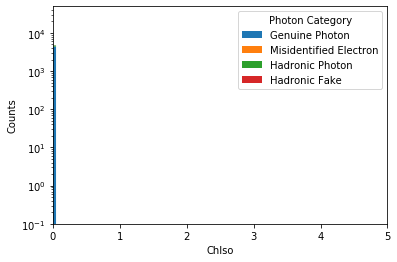

In [6]:
h = output['photon_chIso'].sum("dataset").sum("year").sum("lepFlavor").rebin('chIso',hist.Bin("chIso",'ChIso',np.arange(0,20.001,.05)))
plotInfo = hist.plot1d(hist=h,stack=True,overlay='category')
ax = plotInfo[1]
ax.set_ylim(1e-1,ax.get_ylim()[-1]*10)
ax.set_xlim(0,5)

ax.set_yscale('log')


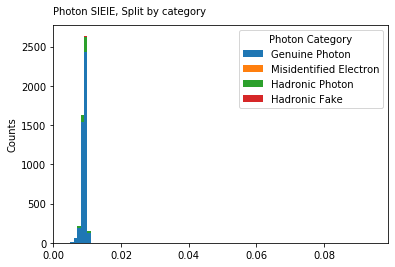

In [7]:
h = output['photon_sieie'].sum("dataset").sum("year").sum("lepFlavor").rebin('sieie',hist.Bin("sieie",'',np.arange(0,0.1,.001)))
plotInfo=hist.plot1d(hist=h, stack=True,overlay='category');
plt.text(plotInfo[1].get_xlim()[0],plotInfo[1].get_ylim()[1]*1.05,'Photon SIEIE, Split by category');

Plot by samples instead of photon categories

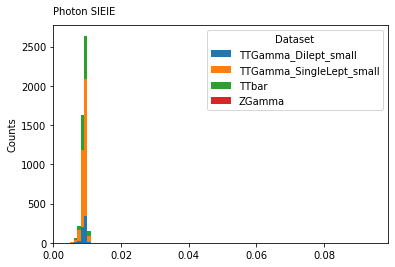

In [8]:
h = output['photon_sieie'].sum("category").sum("year").sum("lepFlavor").rebin('sieie',hist.Bin("sieie",'',np.arange(0,0.1,.001)))
plotInfo = hist.plot1d(hist=h,stack=True,overlay='dataset');
plt.text(plotInfo[1].get_xlim()[0],plotInfo[1].get_ylim()[1]*1.05,'Photon SIEIE');

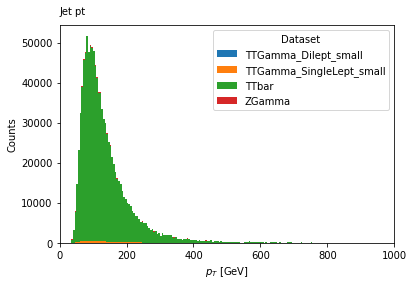

In [9]:
plotInfo = hist.plot1d(output['pt_jet'].integrate('year','2016').sum("lepFlavor").sum("nBjet").sum("nPho"),overlay='dataset',stack=True);
plt.text(plotInfo[1].get_xlim()[0],plotInfo[1].get_ylim()[1]*1.05,'Jet pt');

Group all ttgamma into one

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/coffea/hist/hist_tools.py:337: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x111db6e10>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


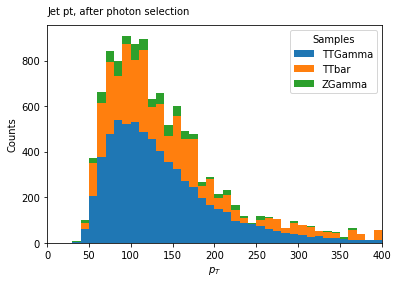

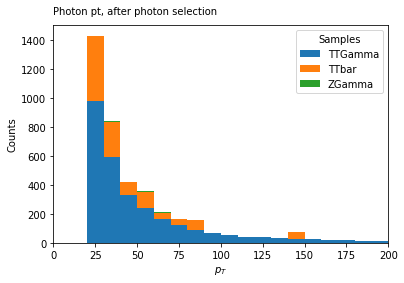

In [10]:
x={ 'TTGamma':['TTGamma_Dilepton_small','TTGamma_SingleLept_small','TTGamma_Hadronic_small'],
    'ZGamma'             : 'ZGamma',
    'TTbar'             : 'TTbar',
  }

h = output['pt_jet'].group('dataset',hist.Cat(r'dataset',r'Samples'),x).sum('year').sum("lepFlavor").sum("nBjet").integrate("nPho",slice(1,None))
h = h.rebin('pt',hist.Bin('pt','$p_{T}$',np.arange(0,400.1,10)))
plotInfo = hist.plot1d(h,overlay='dataset',stack=True)
plt.text(plotInfo[1].get_xlim()[0],plotInfo[1].get_ylim()[1]*1.05,'Jet pt, after photon selection');

h = output['photon_pt'].group('dataset',hist.Cat(r'dataset',r'Samples'),x).integrate('year').sum('category').sum("lepFlavor")
h = h.rebin('pt',hist.Bin('pt','$p_{T}$',np.arange(0,200.1,10)))
plotInfo = hist.plot1d(h,overlay='dataset',stack=True)
plt.text(plotInfo[1].get_xlim()[0],plotInfo[1].get_ylim()[1]*1.05,'Photon pt, after photon selection');

Select single dataset

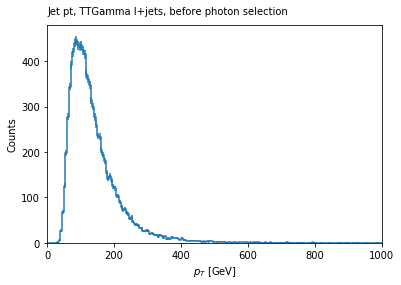

In [11]:
plotInfo = hist.plot1d(output['pt_jet'].integrate('year','2016').sum("lepFlavor").sum("nBjet").sum("nPho").integrate('dataset','TTGamma_SingleLept_small'));
plt.text(plotInfo[1].get_xlim()[0],plotInfo[1].get_ylim()[1]*1.05,'Jet pt, TTGamma l+jets, before photon selection');

Delta R split by sample and split by photon category

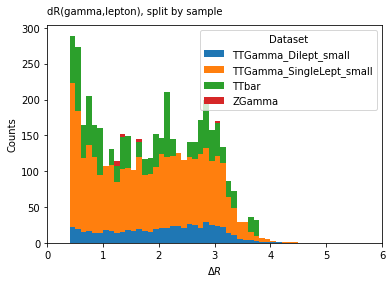

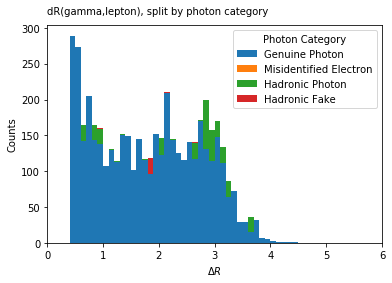

In [12]:
h = output['dR_lep_gamma'].rebin('dR',hist.Bin('dR','$\Delta R$',np.arange(0,6.1,.1)))
plotInfo = hist.plot1d(h.sum('year').sum('category').sum("lepFlavor"),stack=True,overlay='dataset');
plt.text(plotInfo[1].get_xlim()[0],plotInfo[1].get_ylim()[1]*1.05,'dR(gamma,lepton), split by sample');
plotInfo = hist.plot1d(h.sum('year').sum('dataset').sum("lepFlavor"),stack=True,overlay='category');
plt.text(plotInfo[1].get_xlim()[0],plotInfo[1].get_ylim()[1]*1.05,'dR(gamma,lepton), split by photon category');


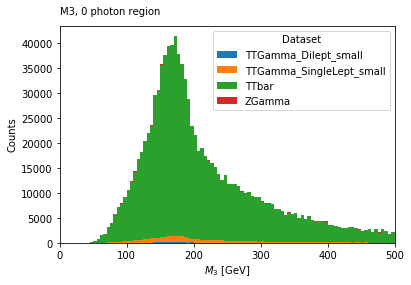

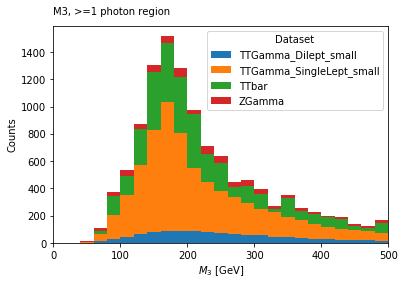

In [13]:
h = output['M3'].sum("year").integrate('nPho',0).sum("lepFlavor").sum("nBjet").rebin('M3',hist.Bin("M3",'$M_{3}$ [GeV]',np.arange(0,500.1,5)))#.rebin('mass',hist.Bin("mass",'',np.arange(0,500.1,10)))
plotInfo = hist.plot1d(hist=h,stack=True,overlay='dataset');
plt.text(plotInfo[1].get_xlim()[0],plotInfo[1].get_ylim()[1]*1.05,'M3, 0 photon region');

h = output['M3'].sum("year").integrate('nPho',slice(1,None)).sum("lepFlavor").sum("nBjet").rebin('M3',hist.Bin("M3",'$M_{3}$ [GeV]',np.arange(0,500.1,20)))
plotInfo = hist.plot1d(hist=h,stack=True,overlay='dataset');
plt.text(plotInfo[1].get_xlim()[0],plotInfo[1].get_ylim()[1]*1.05,'M3, >=1 photon region');


Plot 2016 Only

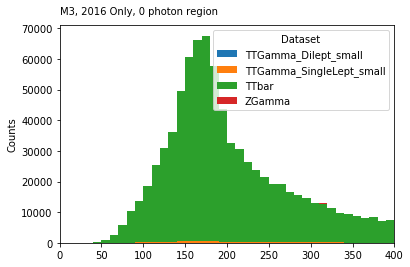

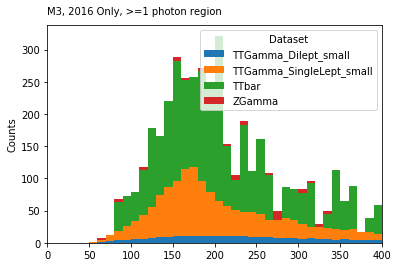

In [14]:
h = output['M3'].integrate("year",'2016').sum('lepFlavor').integrate('nBjet',slice(1,None)).rebin('M3',hist.Bin("M3",'',np.arange(0,400.1,10)))
plotInfo = hist.plot1d(hist=h.integrate('nPho',0),stack=True,overlay='dataset');
plt.text(plotInfo[1].get_xlim()[0],plotInfo[1].get_ylim()[1]*1.05,'M3, 2016 Only, 0 photon region');

plotInfo = hist.plot1d(hist=h.integrate('nPho',slice(1,None)),stack=True,overlay='dataset');
plt.text(plotInfo[1].get_xlim()[0],plotInfo[1].get_ylim()[1]*1.05,'M3, 2016 Only, >=1 photon region');


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/coffea/hist/hist_tools.py:337: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x111db6e10>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


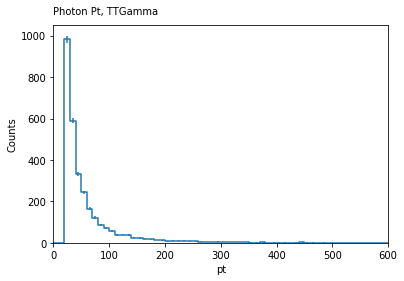

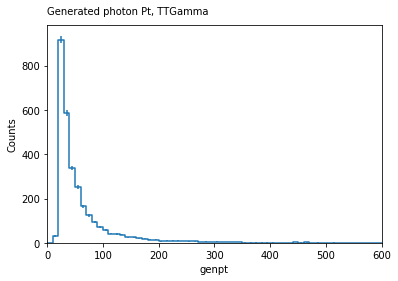

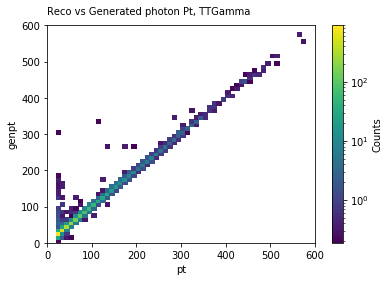

In [15]:
h = output['photon_RecoVsGenPt'].sum('year').sum('category').sum('lepFlavor').integrate('dataset',['TTGamma_SingleLept_small','TTGamma_DiLept_small'])

h = h.rebin('pt',hist.Bin("pt","pt",60,0,600)).rebin('genpt',hist.Bin("genpt","genpt",60,0,600))

plotInfo=hist.plot1d(h.sum("genpt"))
plt.text(plotInfo[1].get_xlim()[0],plotInfo[1].get_ylim()[1]*1.05,'Photon Pt, TTGamma');

plotInfo=hist.plot1d(h.sum("pt"))
plt.text(plotInfo[1].get_xlim()[0],plotInfo[1].get_ylim()[1]*1.05,'Generated photon Pt, TTGamma');

plotInfo=hist.plot2d(h,xaxis="pt",patch_opts={'norm':colors.LogNorm()})
plt.text(plotInfo[1].get_xlim()[0],plotInfo[1].get_ylim()[1]*1.05,'Reco vs Generated photon Pt, TTGamma');


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/coffea/hist/hist_tools.py:337: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x111db6e10>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


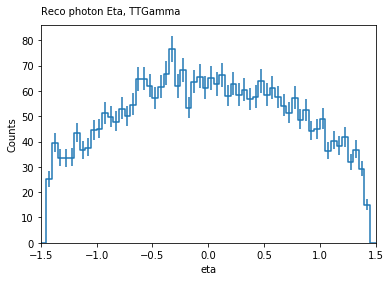

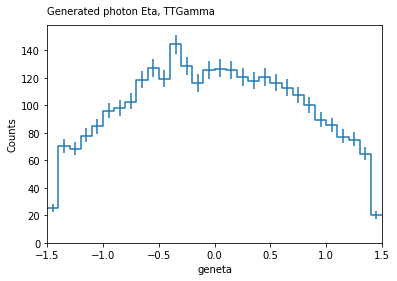

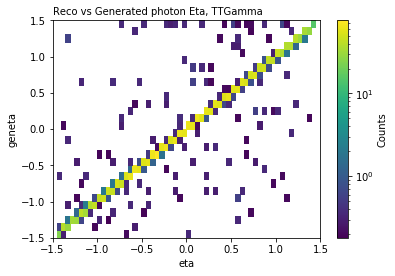

In [16]:
h = output['photon_RecoVsGenEta'].sum('year').sum('category').sum('lepFlavor').integrate('dataset',['TTGamma_SingleLept_small','TTGamma_DiLept_small'])

h = h.rebin('eta',hist.Bin("eta","eta",np.arange(-1.5,1.5001,0.05))).rebin('geneta',hist.Bin("geneta","geneta",np.arange(-1.5,1.5001,0.1)))#30,-1.5,1.50001))

plotInfo=hist.plot1d(h.sum("geneta"))
plt.text(plotInfo[1].get_xlim()[0],plotInfo[1].get_ylim()[1]*1.05,'Reco photon Eta, TTGamma');

plotInfo=hist.plot1d(h.sum("eta"))
plt.text(plotInfo[1].get_xlim()[0],plotInfo[1].get_ylim()[1]*1.05,'Generated photon Eta, TTGamma');

plotInfo=hist.plot2d(h,xaxis="eta",patch_opts={'norm':colors.LogNorm()})
plt.text(plotInfo[1].get_xlim()[0],plotInfo[1].get_ylim()[1]*1.05,'Reco vs Generated photon Eta, TTGamma');


In [17]:
with open('outputTest.pkl','wb') as _file:
    pickle.dump(output,_file)